In [529]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hypertools as hyp
import time, glob, itertools
import geoplot as gplt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib inline

In [530]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)

In [531]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})


In [532]:
frame['HUC_12']=frame.HUC_12.astype(str)

In [533]:
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [534]:
inHouse=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\inhouse_elemental.csv')

In [535]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(inHouse.longitude, inHouse.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(inHouse, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

In [536]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [537]:
validations=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\validationmap.csv')

In [913]:
val_huc = val_huc.merge(validations, on='Sample_ID')

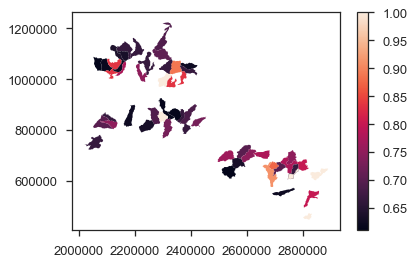

In [694]:
fig, ax = plt.subplots()
CaptainHucstable[(CaptainHucstable['element']=='ag_ppm') & (CaptainHucstable['formation'] =='Wagon Bed Formation') &
                (CaptainHucstable['bins_ppm']>=0.5) & (CaptainHucstable['prob']>0.6)].plot(ax=ax, column='prob', legend=True)
#val_huc[val_huc['Sample_ID']==validations.loc[0].Sample_ID].plot(ax=ax, color='green')


In [933]:
val_huc.loc[0][34]

0.5

In [ ]:
df=pd.DataFrame(columns=val_huc.columns[34:-1])
df['Sample_ID'] = val_huc.Sample_ID

for samples in tqdm(range(len(val_huc))):
    a = val_huc.loc[samples].HUC_12 #select the samples huc
    formation = val_huc.loc[samples].formation[0:10]
    for element in range(34,99):
        ppm = val_huc.columns[element] #select each element in the list
        valued = val_huc.loc[samples][element] #select each elements values 
        #from the big list, select element, formation, and concentration greater than the sample has, and create a list of the
        #basins that we should explore
        b = CaptainHucstable[(CaptainHucstable['element']== ppm) & (CaptainHucstable['formation'].str.contains(formation)) &(
            CaptainHucstable['bins_ppm']>= valued) & (CaptainHucstable['prob']>0.6)].HUC_12.values
        if list(set(a) & set(b)) =='':
            df[ppm].iloc[samples]=0 #if they don't match we record a 0
        else:
            df[ppm].iloc[samples]=1 #if the actual HUC matches the list of predicted HUC's then we record a 1
    
accuracyMeasure=[]
for i in range(len(df)):
    accuracyMeasure.append(df.loc[i].values[0:-1].sum()/len(df.loc[i].values[0:-1]))

 17%|█████████████▏                                                                | 17/101 [32:10<2:39:00, 113.58s/it]

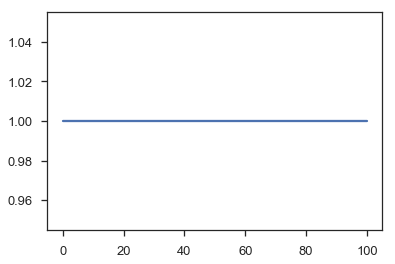

In [989]:
plt.plot(accuracyMeasure)